In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from datetime import datetime
import NSMap as ns
from matplotlib.patches import ConnectionPatch
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors

# Analysis of Newport Line Dataset

Here we assess the nonstationarity of time series of several species of plankton which were subject to an extreme heatwave event in 2014-2016. Measurements were taken very irregularly, so instead of using the raw time series, we average all observations taken within a given month. Only a handful of months had no observations - these were left as null.

In [14]:
# these are the most abundant species from the Newport Line, and are the only ones analyzed
top_4_species = ['PSEUDOCALANUS', 'OIKOPLEURA', 'ACARTIA LONGIREMIS', 'PARACALANUS PARVUS']

table = np.loadtxt("../datasets/newport_aggregated_series.csv", delimiter=",")

# create a dictionary which maps each species name to its respective time series
species_dict = dict()
for i, species in enumerate(top_4_species):
    species_dict[species] = table[:,i]

# Tau Determination

In [5]:
""" Uncomment this code to rerun 
h = 0
E_max = 6
taus = np.arange(1,7)
r_sqrd_table = np.zeros((len(taus), 4))

for i, species in enumerate(top_4_species):
    ts = species_dict[species]

    r_sqrds = [get_delta_agg(ts, E_max, tau=tau,
                             return_forecast_skill=True)[2] 
                   for tau in taus]
    r_sqrd_table[:, i] = r_sqrds

np.savetxt("../results/newport_multiwindow/newport_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")
"""

' Uncomment this code to rerun \nh = 0\nE_max = 6\ntaus = np.arange(1,7)\nr_sqrd_table = np.zeros((len(taus), 4))\n\nfor i, species in enumerate(top_4_species):\n    ts = species_dict[species]\n\n    r_sqrds = [get_delta_agg(ts, E_max, tau=tau,\n                             return_forecast_skill=True)[2] \n                   for tau in taus]\n    r_sqrd_table[:, i] = r_sqrds\n\nnp.savetxt("../results/newport_multiwindow/newport_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")\n'

In [6]:
# or don't rerun the above block and just use these precomputed values
r_sqrd_table = np.loadtxt("../results/newport_multiwindow/newport_rsqrd_vs_tau.csv", delimiter=",")

In [8]:
# Check Autocorrelation
taus = np.arange(1,7)
autocorr_table = np.zeros((len(taus), 4))

for i, species in enumerate(top_4_species):
    ts = species_dict[species]
    ts_no_NA = ts[~np.isnan(ts)]
    autocorr_table[:,i] = np.array([np.corrcoef(ts_no_NA[tau:], ts_no_NA[:-tau])[0,1]
                                      for tau in taus])

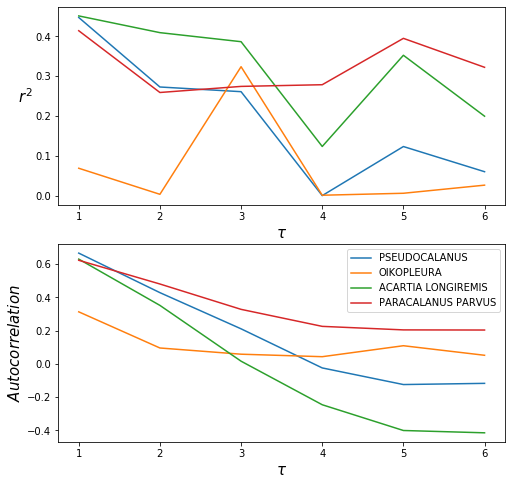

In [9]:
fig, ax = plt.subplots(2, figsize=(8,8))
for i, species_label in enumerate(top_4_species):
    ax[0].plot(taus, r_sqrd_table[:,i], label=species_label)
    ax[1].plot(taus, autocorr_table[:,i], label=species_label)

ax[0].set_ylabel(r"$r^2$", fontsize = 15, rotation = 0, labelpad=10)
ax[0].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)

ax[1].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)
ax[1].set_ylabel(r"$Auto correlation$", fontsize = 15, rotation = 90)

plt.legend()

Final choice is tau = 3 across all series as autocorrelations diminishes for all series while retaining solid forecast skill across the board. Note that the strongly negative autocorrelation for Paracalanus Parvus at high lags is as bad as positive autocorrelation.

# Effect of Time Window on Pseudocalanus
The point of this experiment is to determine the impact of time series window on our assessment of nonstationarity. We conjecture that at intermediate time series lengths we will get the most nonstationarity positives. To test this, we assess nonstationarity for all subsequences of the original time series with length a multiple of 12, and starting index is a multiple of 12.

In [10]:
def drawBracket(start_year, length, ax):
    start_index = start_year - 1996
    length_index = 26 - length
    ax.plot(np.array([start_index, start_index + length ]),
            np.ones(2)*length_index, c="black")
    
# Convert the delta values for each subseries into a square matrix
# which is plotted using matplotlib's imshow.
def makeHeatMapNewport(results):
    nonstationarityHeatMap = np.zeros((25,25)) * np.nan
    for l, o, d, t, r in results:
        i_length = 24-(int(l/12) - 2)
        i_offset = int(o/12)
        nonstationarityHeatMap[i_length, i_offset] = d
    return nonstationarityHeatMap

def makeFigureNewport(nonstationarityHeatMap, ts, name, ax):
    name_to_fig_title = {'Oikopleura' : 'Figure_S12',
                         'Acartia longiremis' : 'Figure_S13',
                         'Paracalanus parvus' : 'Figure_S14'}
    
    im = ax.imshow(np.log(nonstationarityHeatMap[:-3]+1), cmap=custom_cmap)
    ax.set_xticks(np.arange(0,26+1,step=2))
    ax.set_xlim(-1.08,27.7)

    ax.set_ylabel("Time series length (years)",fontsize=15)
    ax.set_yticks(np.arange(-1,22+1))
    ax.set_yticklabels(np.flip(np.hstack([np.arange(4,25+1)+1,""])))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=15)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    axTS.plot(np.linspace(1996.264,2022.335,num=312), ts,c="dodgerblue")
    axTS.set_xticks(np.arange(1996,2022+1,step=2))
    axTS.set_yticks([])
    axTS.set_ylabel(name, fontsize= 12, style='italic')
    axTS.set_xlabel("Start year",fontsize=15)

    plt.savefig(f"../PDF_figures_tables/newport_multiwindow/{name_to_fig_title[name]}.pdf", format="pdf", bbox_inches="tight")

In [11]:
# Compute the nonstationarity of windows of each series. This has
# been precomputed, uncomment to run again to regenerate results.

"""
E_max = 5
tau = 3

for index, species in enumerate(top_4_species):
    ts = species_dict[species]

    maxLen = ts.shape[0]
    lengths = np.arange(24,maxLen+1,step=12)

    n_rows = 325
    # length, starting index, delta, theta, r_sqrd
    results = np.zeros((n_rows, 5))
    tally = 0

    for length in lengths:
        for start in np.arange(0, maxLen - length+1, step=12):
            ts_chunk = ts[start:length+start]
            try:
                delta, theta, r_sqrd = ns.get_delta_agg(ts_chunk, E_max-1, tau=tau, return_forecast_skill=True)
            except:
                delta, theta, r_sqrd = (0,0,0)
            delta, theta, r_sqrd = ns.get_delta_agg(ts_chunk, E_max-1, tau=tau, return_forecast_skill=True)
            results[tally] = np.array([length, start, delta, theta, r_sqrd])
            tally += 1

    np.savetxt(f"../results/newport_multiwindow/{species}_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")
    """

'\nE_max = 5\ntau = 3\n\nfor index, species in enumerate(top_4_species):\n    ts = species_dict[species]\n\n    maxLen = ts.shape[0]\n    lengths = np.arange(24,maxLen+1,step=12)\n\n    n_rows = 325\n    # length, starting index, delta, theta, r_sqrd\n    results = np.zeros((n_rows, 5))\n    tally = 0\n\n    for length in lengths:\n        for start in np.arange(0, maxLen - length+1, step=12):\n            ts_chunk = ts[start:length+start]\n            try:\n                delta, theta, r_sqrd = ns.get_delta_agg(ts_chunk, E_max-1, tau=tau, return_forecast_skill=True)\n            except:\n                delta, theta, r_sqrd = (0,0,0)\n            delta, theta, r_sqrd = ns.get_delta_agg(ts_chunk, E_max-1, tau=tau, return_forecast_skill=True)\n            results[tally] = np.array([length, start, delta, theta, r_sqrd])\n            tally += 1\n\n    np.savetxt(f"../results/newport_multiwindow/{species}_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")\n    '

In [12]:
# Create custom color map
orange_rgba = colors.to_rgba("orange")
dodgerblue_rgba = colors.to_rgba("dodgerblue")
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [dodgerblue_rgba, orange_rgba]) 

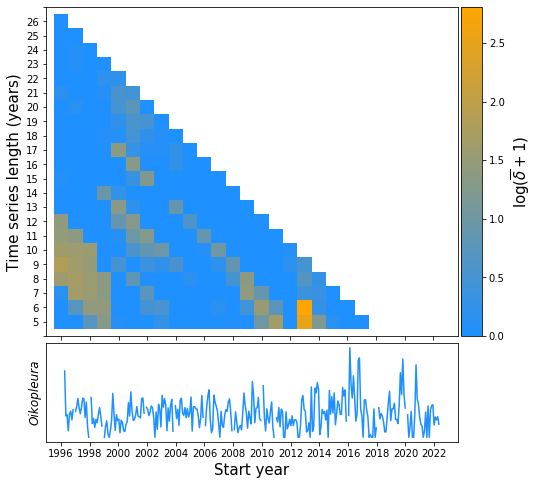

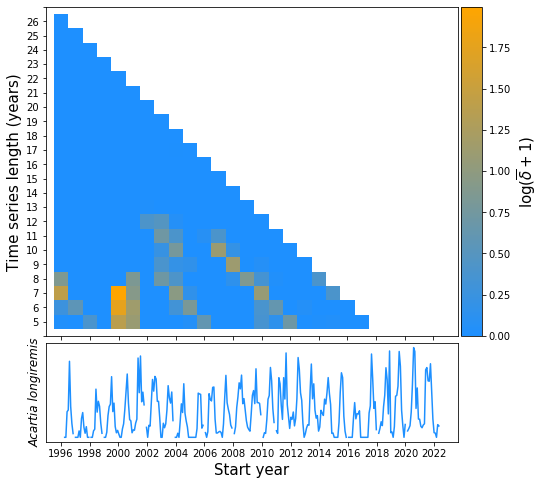

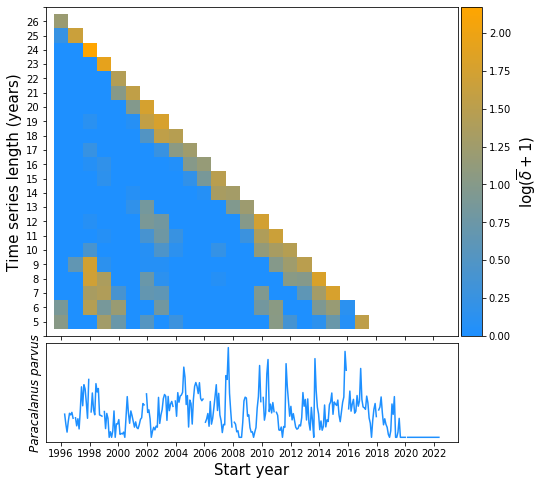

In [13]:
# Produce the plots for each series
for index, species in zip([1,2,3], top_4_species[1:]):
    fig, ax = plt.subplots(1,figsize=(8,8))
    species_list = ['Pseudocalanus', 'Oikopleura', 'Acartia longiremis', 'Paracalanus parvus']

    results = np.loadtxt(f"../results/newport_multiwindow/{species}_time_window.csv", delimiter=",")
    lengths = np.unique(results[:,0])
    
    ts = species_dict[species]
    nonstationarityHeatMap = makeHeatMapNewport(results)
    makeFigureNewport(nonstationarityHeatMap, ts, species_list[index], ax)